## Sampling

We want to evaluate this expresion:

$$
E[f] = \int f(x)p(x) dx
$$

Which is not always possible or easy to do. So, we can use sampling instead.

$$
E[\hat{f}] = \frac{1}{N} \sum_{i=1}^N f(x^{(i)})
$$

Where $x^{(i)}$ are samples drawn independently from the distribution $p(x)$

## Central Limit Theorem

In [1]:
"""
Create some values of X
"""
import numpy as np

np.random.seed(23)

x = np.arange(0,100,0.5)
x[:10]

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

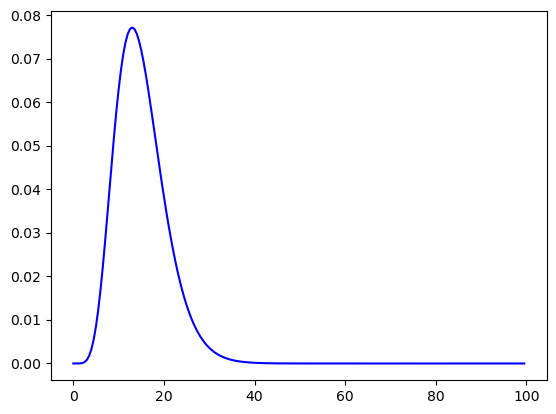

In [2]:
from scipy.stats import chi2
import matplotlib.pyplot as plt

"""
Suppose we have a distribution we can sample of, but cannot integrate
"""
plt.plot(x, chi2.pdf(x, df=15), c='blue')

In [3]:
"""
Generate multiple samples of the distributions and store its sum
"""

n_sums = 1000
n_samples = 300
sum_arr = np.zeros(n_sums)

for i in range(n_sums):
    sum_arr[i] = np.sum(chi2.rvs(df=15, size=n_samples))

sum_arr = np.sort(sum_arr) 
sum_mu = np.mean(sum_arr)
sum_std = np.std(sum_arr)

print(sum_mu)
print(sum_std)

4499.698589711441
90.73714534868404


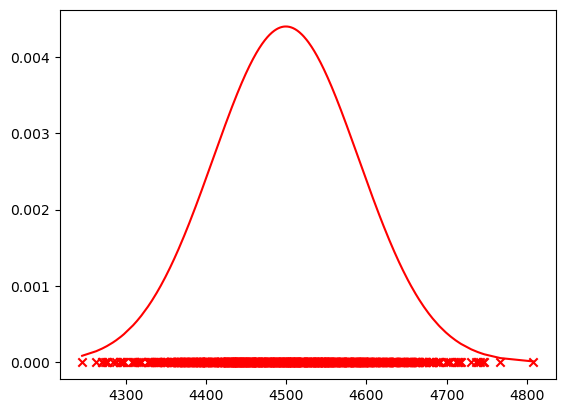

In [4]:
"""
Notice the sums follow a Normal distribution, this is the central limit theorem
"""

from scipy.stats import norm

plt.plot(sum_arr, norm.pdf(sum_arr, sum_mu, sum_std), c='red')
plt.scatter(sum_arr, np.zeros(n_sums), c='red', marker='x')

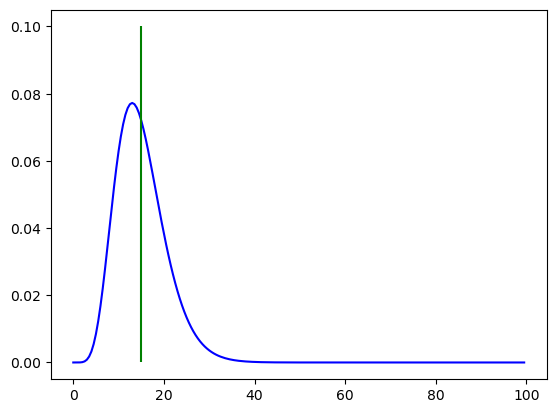

In [5]:
"""
The expectation of the original distribution is close to MU / N, where MU is the sample mean of the sums, and
N is the number of samples from the original distribution on each iteration.
"""

plt.plot(x, chi2.pdf(x, df=15), c='blue')
plt.vlines(sum_mu / n_samples, ymin=0, ymax=0.1, color = 'green')

In [6]:
print(chi2.mean(df=15))
print(sum_mu / n_samples)

15.0
14.998995299038137


## Sampling by Inverse

By this point you have realized that sampling is important, there are different ways to do it. The simplest one is using the inverse method. 

In [7]:
def exp_pdf(x, l=1):
    """
    Suppose we want to sample from this distribution (exponential)
    """
    return l * np.exp(-l * x)

In [8]:
def exp_cdf(x, l=1):
    """
    By integrating it from 0 to x we obtain the cumulative distribution
    """
    return 1 - np.exp(-l * x)

In [9]:
def exp_inv(y, l=1):
    """
    Solving the CDF for x, we get the inverse function 
    """
    return -np.log(1 - y) / l

In [10]:
"""
Define some X
"""

x = np.arange(0,10,0.1)
x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

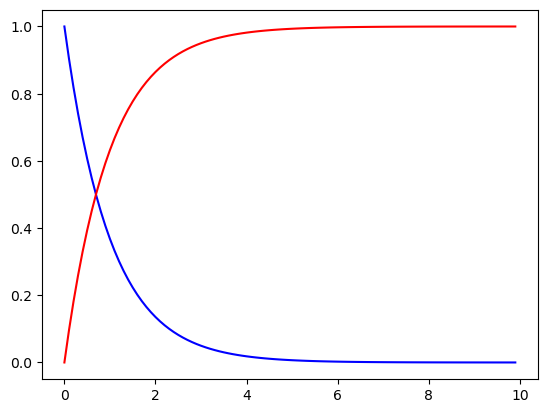

In [11]:
"""
Plot the probability and the cumulative function
"""

plt.plot(x, exp_pdf(x), c='blue')
plt.plot(x, exp_cdf(x), c='red')

In [12]:
"""
Generate some random numbers uniformily in [0, 1]
"""

u = np.random.uniform(low=0.0, high=1.0, size=20)
u

array([0.88005145, 0.30405349, 0.76314778, 0.73473184, 0.49598408,
       0.57613765, 0.80710965, 0.79321808, 0.99319619, 0.23054541,
       0.00942056, 0.63750185, 0.41995683, 0.9147446 , 0.40775501,
       0.25494886, 0.91386922, 0.70127879, 0.09077044, 0.30197716])

In [13]:
"""
Using the inverse function with the random generated values,
we obtain samples from the original distribution
"""

sample = exp_inv(u)
sample

array([2.1206924 , 0.36248248, 1.44031888, 1.32701403, 0.68514742,
       0.85834652, 1.64563339, 1.57609056, 4.99027262, 0.26207334,
       0.00946521, 1.01473591, 0.54465274, 2.46210383, 0.5238349 ,
       0.29430242, 2.45188841, 1.20824455, 0.09515768, 0.35950345])

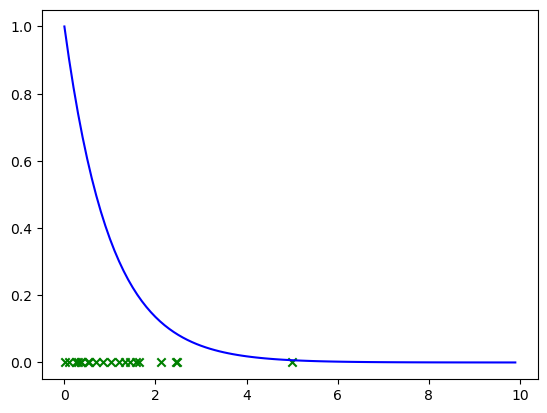

In [14]:
plt.plot(x, exp_pdf(x), c='blue')
plt.scatter(sample, np.zeros(len(sample)), c='green', marker='x')

## Rejection Sampling

We sample observations from abother distribution, called, the **proposal distribution**, $q(x)$, where: 

$$
kq(x) \geq f(x)
$$

Then, an observation, $x$,  is accepted with probability

$$
\frac{f(x)}{kq(x)}
$$

**Remember that $f$ is a function we can evaluate, but we cannot sample from.**

In [15]:
from scipy.stats import multivariate_normal

def gmm_pdf(x):
    """
    Let's use a gaussian mixture as the original distribution, f(x)
    """
    n = len(x)
    k = 2
    w = np.array([0.5, 0.5])
    mu = np.array([-10, 6])
    sigma2 = np.array([10, 1])
    
    pdf = np.zeros((n, k))
    for i in range(k):
        pdf[:, i] = w[i] * multivariate_normal(mu[i], sigma2[i]).pdf(x)
        
    return pdf.sum(axis=1)

In [16]:
def proposal_pdf(x, k=1):
    """
    Let's use a normal distribution (gaussian) as the proposal distribution
    """
    return k * norm(0, 10).pdf(x)

In [17]:
def proposal_sample(size=20, random_state=32):
    """
    This function generates samples from the proposal distribution
    """
    return norm(0, 10).rvs(size=size, random_state=random_state)

In [18]:
"""
Generates an X
"""

x = np.arange(-30,30,0.1)
x[:10]

array([-30. , -29.9, -29.8, -29.7, -29.6, -29.5, -29.4, -29.3, -29.2,
       -29.1])

In [19]:
"""
Evaluates X in f
"""

pdf_x = gmm_pdf(x)
pdf_x.shape

(600,)

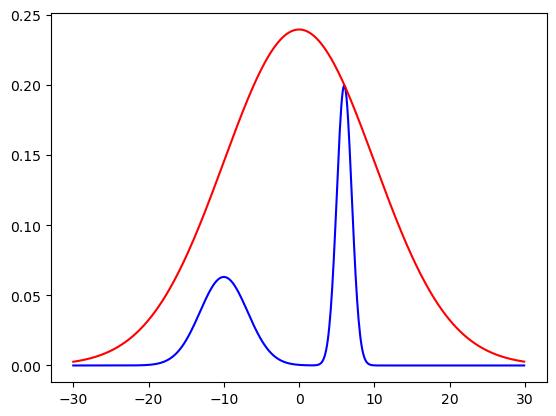

In [20]:
plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=6), c='red')

In [21]:
"""
Generates a sample from the proposal distribution
"""

s = proposal_sample(size=500)
s[:10]

array([-3.48894451,  9.83703433,  5.80922831,  0.70284441,  7.77532676,
        5.81958745, 14.71790527, 16.63181009, -2.61177121, -6.88676813])

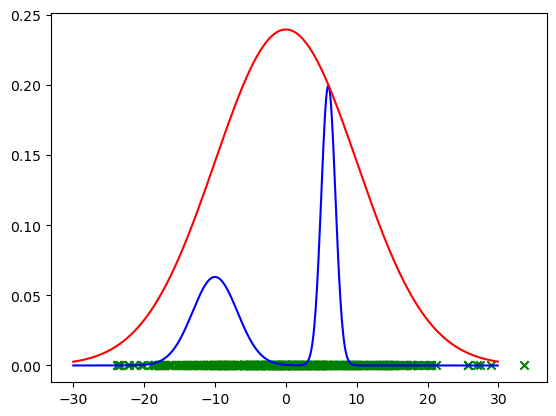

In [22]:
plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=6), c='red')
plt.scatter(s, np.zeros(len(s)), c='green', marker='x')

In [23]:
"""
Compute accept/reject probabilities
"""

probs = gmm_pdf(s) / proposal_pdf(s, k=6)

accept = [prob > np.random.uniform(low=0.0, high=1.0) for prob in probs]
accept[:10]

[False, False, True, False, True, True, False, False, False, False]

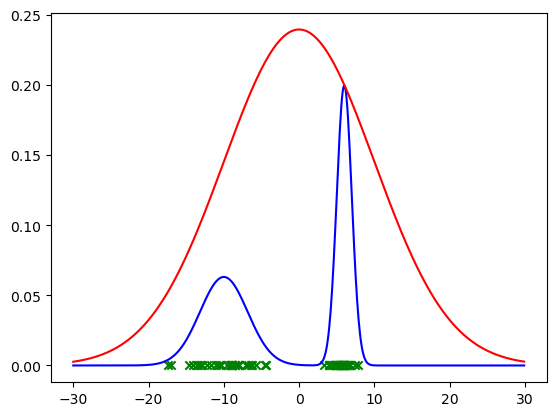

In [24]:
plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=6), c='red')
plt.scatter(s[accept], np.zeros(len(s[accept])), c='green', marker='x')

## Importance Sampling

* Similar to Rejection Sampling, with the difference that all observations survive, but a weight or probability is associated to each observation. 

* Another difference with Rejection Sampling is that the proposal distribution doesn't has to cover the original distribution.

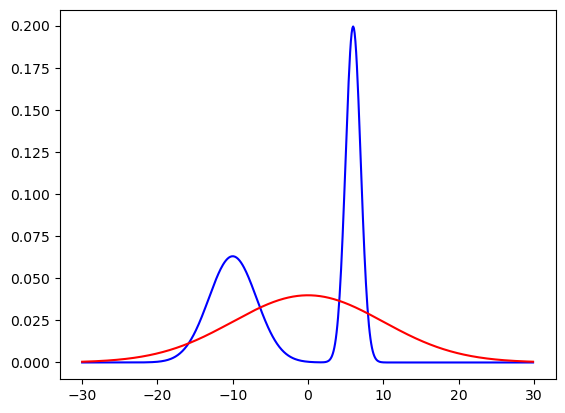

In [25]:
plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=1), c='red')

The importance weights are defined as:

$$
w(x) = \frac{f(x)}{g(x)}
$$

In [26]:
importance_weights = gmm_pdf(s) / proposal_pdf(s, k=1)
importance_weights[:10]

array([2.01758641e-01, 5.15318307e-03, 5.81230874e+00, 5.16347795e-03,
       1.39909289e+00, 5.82700264e+00, 2.52925851e-13, 2.50262922e-15,
       1.06773648e-01, 1.23450812e+00])

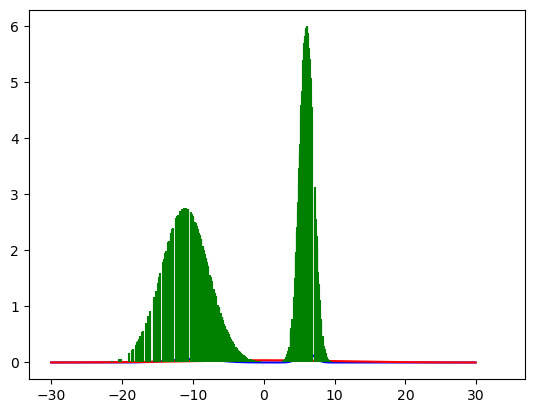

In [27]:
"""
Let's plot the importance weights as green vertical lines
"""

plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=1), c='red')

plt.vlines(s, ymin=0, ymax=importance_weights, color = 'green')

#### Sampling-Importance-Resampling

To generate samples from the original distribution we assign a probability to be sampled to each observation.

$$
p(x_k) = \frac{w(x_k)}{\sum_{i=1}^N w(x_i)}
$$

In [28]:
"""
Calculate importance probabilities
"""

importance_probs = importance_weights / np.sum(importance_weights)

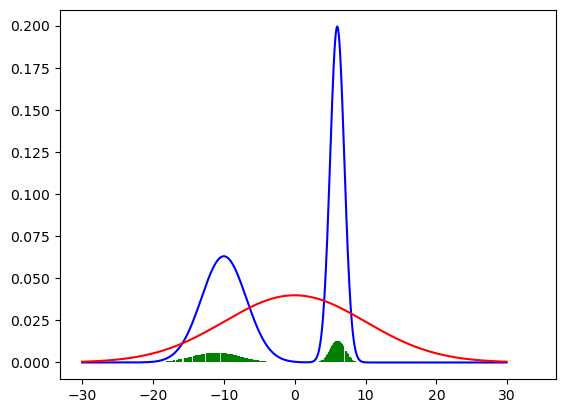

In [29]:
"""
Plot importance probabilities
"""

plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=1), c='red')

plt.vlines(s, ymin=0, ymax=importance_probs, color = 'green')

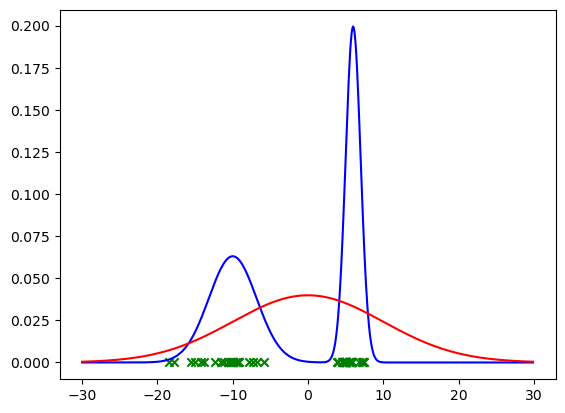

In [30]:
"""
Generate new samples according to their probabilities
"""

importance_samples = np.random.choice(s, size=50, p=importance_probs)

plt.plot(x, pdf_x, c='blue')
plt.plot(x, proposal_pdf(x, k=1), c='red')

plt.scatter(importance_samples, np.zeros(len(importance_samples)), c='green', marker='x')

## Example - Find $\pi$

In [31]:
radius = 0.5

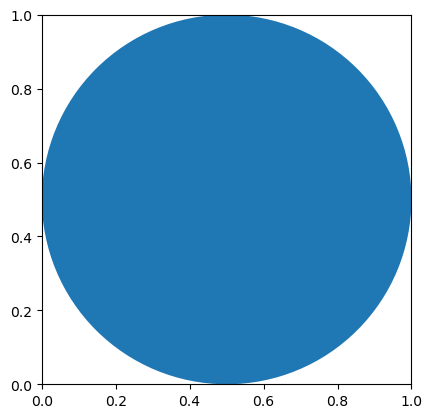

In [32]:
fig, ax = plt.subplots()
Drawing_colored_circle = plt.Circle(( radius , radius ), radius )
 
ax.set_aspect( 1 )
ax.add_artist( Drawing_colored_circle )
plt.show()

In [33]:
n_samples = 10
x_rand = np.random.uniform(low=0.0, high=1.0, size=n_samples)
y_rand = np.random.uniform(low=0.0, high=1.0, size=n_samples)

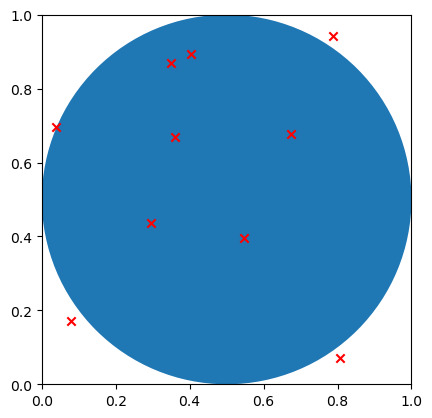

In [34]:
fig, ax = plt.subplots()
Drawing_colored_circle = plt.Circle(( radius , radius ), radius )
 
ax.set_aspect( 1 )
ax.add_artist( Drawing_colored_circle )
ax.scatter(x_rand, y_rand, marker='x', color='red')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.show()

In [35]:
points_inside = np.array([np.sqrt((x - radius)**2 + (y - radius)**2) < radius for x, y in zip(x_rand, y_rand)])

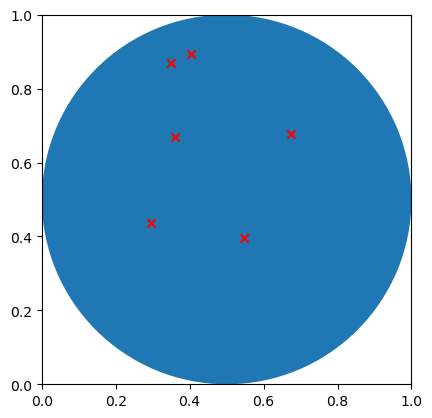

In [36]:
fig, ax = plt.subplots()
Drawing_colored_circle = plt.Circle(( radius , radius ), radius )
 
ax.set_aspect( 1 )
ax.add_artist( Drawing_colored_circle )
ax.scatter(x_rand[points_inside], y_rand[points_inside], marker='x', color='red')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.show()

In [37]:
n_inside = np.sum(points_inside)
n_inside

6

In [38]:
circle_area = n_inside / n_samples
circle_area

0.6

In [39]:
my_pi = circle_area / radius**2
my_pi

2.4